This notebook contents are:

    (0) load model
    (1) image recognition
    (2) estimating RF(receptive field) by reverse correlation 
    (3) estimating RF by activation maximization
    (4) estimating prefered image by activation maximization (not only for first layer)
    (5) encoding and decoding experiment using Alexnet instead of a real brain
    (6) estimating tuning curve for orientation stimulus
    (7) decoding orientation using estimated tuning curve
    (8) image reconstruction from unit activities
    (9) deepdream



In [66]:
import numpy as np

from scipy.misc import imresize
from scipy import interpolate
import scipy.ndimage as nd

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import pickle
import pandas as pd
import time
from datetime import datetime
import os

import chainer
from chainer import Variable
import chainer.links as L
import chainer.functions as F
from chainer.links import caffe
from chainer import serializers

In [2]:
#directory setting
data_dir = 'data'
model_dir = 'model'
fig_dir = 'fig'
temp_dir = 'temp'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)

In [69]:
# Alexnet
class Alex(chainer.Chain):
    insize = 227

    def __init__(self, dropout_rate=0.0):
        super(Alex, self).__init__(
            conv1=L.Convolution2D(None,  96, 11, stride=4),
            conv2=L.Convolution2D(None, 256,  5, pad=2),
            conv3=L.Convolution2D(None, 384,  3, pad=1),
            conv4=L.Convolution2D(None, 384,  3, pad=1),
            conv5=L.Convolution2D(None, 256,  3, pad=1),
            fc6=L.Linear(None, 4096),
            fc7=L.Linear(None, 4096),
            fc8=L.Linear(None, 1000),
        )
        self.dropout_rate = dropout_rate

    def __call__(self, x, layers):
        ret = {}
        en = layers[-1]
        h = self.conv1(x)
        if 'conv1' in layers:
            ret.update({'conv1': h})
            if en == 'conv1':
                return ret
        h = F.max_pooling_2d(F.local_response_normalization(
            F.relu(h)), 3, stride=2)
        h = F.dropout(self.conv2(h), ratio=self.dropout_rate)
        if 'conv2' in layers:
            ret.update({'conv2': h})
            if en == 'conv2':
                return ret
        h = F.max_pooling_2d(F.local_response_normalization(
            F.relu(h)), 3, stride=2)
        h = F.dropout(self.conv3(h), ratio=self.dropout_rate)
        if 'conv3' in layers:
            ret.update({'conv3': h})
            if en == 'conv3':
                return ret
        h = F.relu(h)
        h = F.dropout(self.conv4(h), ratio=self.dropout_rate)
        if 'conv4' in layers:
            ret.update({'conv4': h})
            if en == 'conv4':
                return ret
        h = F.relu(h)
        h = F.dropout(self.conv5(h), ratio=self.dropout_rate)
        if 'conv5' in layers:
            ret.update({'conv5': h})
            if en == 'conv5':
                return ret
        h = F.max_pooling_2d(F.relu(h), 3, stride=2)
        h = F.dropout(self.fc6(h), ratio=self.dropout_rate)
        if 'fc6' in layers:
            ret.update({'fc6': h})
            if en == 'fc6':
                return ret
        h = F.relu(h)
        h = F.dropout(self.fc7(h), ratio=self.dropout_rate)
        if 'fc7' in layers:
            ret.update({'fc7': h})
            if en == 'fc7':
                return ret
        h = F.relu(h)
        h = self.fc8(h)
        if 'fc8' in layers:
            ret.update({'fc8': h})

        return ret

    def predict(self, x):
        h = self.__call__(x, layers='fc8')['fc8']
        h = F.softmax(h)
        return h.data

    def get_layer_names(self):
        return ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']

    def get_whole_units(self, layers):
        ret = {}
        if 'conv1' in layers:
            ret.update({'conv1': [96, 55, 55]})
        if 'conv2' in layers:
            ret.update({'conv2': [256, 27, 27]})
        if 'conv3' in layers:
            ret.update({'conv3': [384, 13, 13]})
        if 'conv4' in layers:
            ret.update({'conv4': [384, 13, 13]})
        if 'conv5' in layers:
            ret.update({'conv5': [256, 13, 13]})
        if 'fc6' in layers:
            ret.update({'fc6': [4096]})
        if 'fc7' in layers:
            ret.update({'fc7': [4096]})
        if 'fc8' in layers:
            ret.update({'fc8': [1000]})
        return ret

In [71]:
# utils
def show_chainer(x):
    if str(type(img)) == "<class 'chainer.variable.Variable'>":
        x = x.data
    x = scaling(x)
    plt.imshow(x[0, [2, 1, 0], :, :].transpose(1, 2, 0).astype(np.float32))
    plt.axis('off')


def scaling(img):
    # 最大値を1、最小値が0になるように線形変換をする。
    temp = img - np.min(img)
    temp = temp/np.max(temp)
    return temp

In [73]:
# for (1)
def preinput(img):
    # convert PIL Image to numpy array for chainer

    # to numpy array
    img = np.asarray(img)
    if not img.shape == (1, 3, 227, 227):
        # resize image to the size used in Alexnet
        img = imresize(img, np.array([227, 227]))
        # to BGR, which is used color order in Alexnet
        img = img[:, :, [2, 1, 0]]
        # reorder img to order used in chainer and convert dtype to np.float32 for chainer
        img = img.transpose(2, 0, 1).astype(np.float32)
        # add batch dimension for chainer
        img = np.expand_dims(img, axis=0)
    return img


def show10results(prediction):
    # load label from outsize
    categories = np.loadtxt(
        '{}/labels.txt'.format(data_dir), str, delimiter="\n")

    # sort to higher score represented label
    result = zip(prediction.reshape((prediction.size,)), categories)
    result = sorted(result, reverse=True)

    # show top 10 results
    print('top 10 percentage category')
    for i, (score, label) in enumerate(result[:10]):
        print('{:>3d} {:>6.2f}% {}'.format(i + 1, score * 100, label))

In [75]:
# for (2)
def imshow_with_zoom(img, pos, zoom=False, d=4):
    # show receptive field

    # img  : img you want to show
    # pos  : position you want to zoom
    # zoom : if zoom is True, you zoom and show the image
    # d    : zoom した場合の大きさ。もし0であれば、conv1のRFのサイズになる。
    

    if zoom:
        plt.imshow(img[pos[0]*4-d:pos[0]*4 + 11 + d,
                       pos[1]*4 - d: pos[1]*4 + 11 + d])
    else:
        plt.imshow(img)
    plt.axis('off')

In [78]:
# for (3),(4)
def am_reg(layer_name, img, ch=0, pos=np.array([5,5]), lam1=0.0001, lam2=0.0001, j=0, lr=1, grad_clip=True, ite=100, pri=False):
    # layer_name : layer name
    # img : image being optimized
    # ch: which channel is used
    # pos : position of unit (used in only conv case)
    # lam1 : coefficient of regularization term about norm
    # lam2 : coefficient of regularization term about smoothness
    # j   : jittering size
    # lr  : initial learning rate
    # grad_clip : normalize gradient size or not
    # ite : iteration of training
    # pri : print loss or not

    img_reg = np.zeros([1, 3, 227, 227]).astype(np.float32) + 128

    unit_act = -100
    for _ in range(ite):

        if j > 0:
            r_jitter = np.random.randint(-j, j+1, 2)
            img = Variable(
                np.roll(np.roll(img.data, r_jitter[0], axis=2), r_jitter[1], axis=3))
        feature = model(img, layers=[layer_name])[layer_name]

        reg1 = F.mean((img - img_reg)**2)
        reg2_1 = F.mean((img[:, :, 1:, :] - img[:, :, :-1, :])**2)
        reg2_2 = F.mean((img[:, :, :, 1:] - img[:, :, :, :-1])**2)
        reg2 = reg2_1 + reg2_2

        if feature.data.ndim == 2:
            loss = -feature[0, ch] + lam1*reg1 + lam2*reg2
        else:
            loss = -feature[0, ch, pos[0], pos[1]] + lam1*reg1 + lam2*reg2

        img.cleargrad()
        loss.backward()
        grad = img.grad

        if grad_clip:
            img.data -= lr * grad / np.mean(np.abs(grad))
        else:
            img.data -= lr * grad

        if j > 0:
            img = Variable(
                np.roll(np.roll(img.data, -r_jitter[0], axis=2), -r_jitter[1], axis=3))

        if np.mod(_, 10) == 0:
            if pri:
                print('----')
                print('iteration : {}'.format(_))
                print('loss      : {}'.format(loss.data))
            if feature.data.ndim == 2:
                if pri:
                    print('unit act  : {}'.format(feature[0, ch].data))
            else:
                unit_act = feature[0, ch, pos[0], pos[1]].data
                if pri:
                    print('unit act  : {}'.format(
                        feature[0, ch, pos[0], pos[1]].data))

    return img

In [32]:
# for (5)
def collect_unit_act(model,img,label,n_unit,n_class,selected_unit_list):
    #collect unit activity with presenting image to Alexnet
    #model  : model such as Alexnet
    #img    : stimulus images
    #label  : classes of stimulus images
    #n_unit : how many unit
    #n_class: how many class
    #selected_unit_list : which unit you use
    
    #return : dictionary containing unit activities and class information
    d = {}
    for ln in ln_list:
        d[ln] = []
    d['class'] = []

    for cl in range(n_class):
        d['class'].append(cl)
        feature = model(img[label == cl][:n_unit],layers=ln_list)
        for ln,su in zip(ln_list,selected_unit_list):
            temp = feature[ln][:].data
            d[ln].append(temp.reshape(len(temp),temp.size/len(temp))[:,su])
    return d


def log_gauss_p(x,m,sig):
    # return logarithm of gaussian probability 
    sig = sig + 1e-8
    return -0.5 * np.log(2 * np.pi) - np.log(sig) - (x-m)**2/2/sig**2

def inference(x,m_list,s_list,n_class):
    # infer class
    
    # x : unit activity that you want to estimate the class
    # m_list : mean of train unit activities
    # s_list : std  of train unit activities
    # n_class : number of candidate class
    p = []
    for k in range(n_class):
        p.append(np.sum(log_gauss_p(x,m_list[k],s_list[k])))
    return np.argmax(p)




def encode_decode(data,n_unit,n_train,n_test,model):
    #n_class = len(data['Category'])
    n_class = 4
    
    #prepare data
    img_train = np.array(data['ImageTrain']).transpose(0,3,1,2).astype(np.float32)
    img_train = img_train[:,[2,1,0],:,:]
    label_train = np.array(data['LabelTrain'])
    img_test = np.array(data['ImageTest']).transpose(0,3,1,2).astype(np.float32)
    img_test = img_test[:,[2,1,0],:,:]
    label_test = np.array(data['LabelTest'])


    #initialize
    feature = model(img_train[0:1], layers=ln_list)
    n_unit_list = [len(feature[ln].data.flatten()) for ln in ln_list]
    selected_unit_list = [np.random.permutation(n_unit_ori)[:n_unit] for n_unit_ori in n_unit_list]

    # collect unit activity using training data
    print('collecting train data')
    d_train = collect_unit_act(model,img_train,label_train,n_train,n_class,selected_unit_list)

    # collect unit activity using testing data
    print('collecting test data')
    d_test = collect_unit_act(model,img_test,label_test,n_test,n_class,selected_unit_list)

    train = pd.DataFrame(d_train)
    test = pd.DataFrame(d_test)

    #最優推定
    #ユニットの活動はガウシアンであると仮定
    print('estimating')
    acc_list = []
    for ln in ln_list:
        #data preparation
        x_train = np.stack(train[ln].values)
        x_train = x_train.reshape(x_train.shape[0] * x_train.shape[1], x_train.shape[2])

        y_train = train['class'].values
        y_train = np.repeat(y_train,n_train)
        x_test = np.stack(test[ln].values)
        x_test = x_test.reshape(x_test.shape[0] * x_test.shape[1], x_test.shape[2])
        y_test = test['class'].values
        y_test = np.repeat(y_test,n_test)
        

        #train (estimate mean and std in each class)
        m_list = []
        s_list = []
        for k in range(n_class):
            temp = x_train[y_train == k]
            m = np.mean(temp,axis=0)
            s = np.std (temp,axis=0)
            m_list.append(m)
            s_list.append(s)
        #ML
        pred = []
        for k in range(len(x_test)):
            pred.append(inference(x_test[k,:],m_list,s_list,n_class))

        acc = np.mean(np.array(pred) == y_test)
        acc_list.append(acc)
    

#     plt.figure(figsize=[20,10])
#     plt.plot(acc_list)
#     plt.hlines(1.0/n_class,0,len(acc_list))
#     a = plt.xticks(np.arange(len(acc_list)),ln_list)
#     plt.ylabel('accuracy')
#     plt.xlabel('layer name')
    
    return acc_list

In [36]:
# for (6)
def make_data(theta,omega,k=0,show = False):
    # make orientation image
    img = make_orientation_image(theta=theta,omega = omega,k = k,size = 227)
    img = img.astype(np.float32)
    img = np.expand_dims(img.transpose(2,0,1),axis=0)
    return img
def make_orientation_image(theta,omega,k = 0,size = 227):
    # make orientation image
    x = np.arange(-size/2.0,size/2.0)
    y = np.arange(-size/2.0,size/2.0)

    xx = np.matlib.repmat(x,len(x),1)
    yy = np.matlib.repmat(y,len(y),1).T
    
    xy_rotation = xx*np.cos(theta)-yy*np.sin(theta)
    wave = np.cos(xy_rotation*omega+k)
    temp = wave - np.min(wave)
    wave = temp / np.max(temp)*255
    wave = np.stack([wave]*3,axis=2).astype(np.uint8)
    return(wave)

def pi_to_deg(x):
    return x/np.pi*180
    

In [43]:
# for (8)
def icnn(layer_name,img,fea_target,lam1 =0.0001,lam2=0.0001,j=0,lr = 1,grad_clip = True,ite=100,pri = False):
    #layer_name : layer name
    #img : image being optimized
    #fea_target : target feature obtained from original image
    #lam1 : coefficient of regularization term about norm
    #lam2 : coefficient of regularization term about smoothness
    #j   : jittering size
    #lr  : initial learning rate
    #grad_clip : normalize gradient size or not
    #ite : iteration of training
    #pri : print loss or not
    
    img_reg = np.zeros([1,3,227,227]).astype(np.float32) + 128
    
    for _ in range(ite):
        
        if j > 0:
            r_jitter = np.random.randint(-j,j+1,2)
            img = Variable(np.roll(np.roll(img.data,r_jitter[0],axis=2),r_jitter[1],axis=3))
        feature = model(img,layers=[layer_name])[layer_name]

        # pixel loss
        reg1   = F.mean((img - img_reg)**2)
        # smoothness
        reg2_1 = F.mean((img[:,:,1:,:] - img[:,:,:-1,:])**2)
        reg2_2 = F.mean((img[:,:,:,1:] - img[:,:,:,:-1])**2)
        reg2 = reg2_1 + reg2_2
        
        # calculate loss
        loss = F.mean((feature - fea_target)**2) + lam1*reg1 + lam2*reg2
        
        # calculate gradient
        img.cleargrad()
        loss.backward()
        grad = img.grad
        
        # update
        if grad_clip:
            img.data -= lr * grad / np.mean(np.abs(grad))
        else:
            img.data -= lr * grad
            
        if j > 0:
            img = Variable(np.roll(np.roll(img.data,-r_jitter[0],axis=2),-r_jitter[1],axis=3))
        
        # report
        if np.mod(_,10) == 0:
            if pri:
                print('----')
                print('iteration : {}'.format(_))
                print('loss      : {}'.format(loss.data))

    return img



In [52]:
# for (9)
class CaffeNet(caffe.CaffeFunction):
    def __init__(self, model_path):
        super(CaffeNet, self).__init__(model_path)

    def preprocess(self, image):
        return np.rollaxis(image[:,:,::-1] - self.mean, 2)

    def deprocess(self, image):
        return (np.rollaxis(image, 0, image.ndim) + self.mean)[:,:,::-1]

class GoogleNet(CaffeNet):
    def __init__(self, model_path):
        super(GoogleNet, self).__init__(model_path)
        self.mean = np.asarray([104, 116, 122], dtype=np.float32)

    def __call__(self, x, outputs=['loss3/classifier']):
#        return self.func(inputs={'data': x}, outputs=outputs, disable=['loss1/ave_pool', 'loss2/ave_pool'], train=False)
        return super(GoogleNet, self).__call__(inputs={'data': x}, outputs=outputs, disable=['loss1/ave_pool', 'loss2/ave_pool', 'inception_4d/1x1', 'inception_4d/3x3_reduce', 'inception_4d/5x5_reduce', 'inception_4d/pool'])


def update(img,model,ln):

    step_size = 1.5
    step_num = 10
    oc_scale = 1.4
    oc_num = 4
    #ln = 'inception_3a/output'


    octaves = [img]
    for k in range(oc_num-1):
        octaves.append(nd.zoom(octaves[-1],(1,1,1/oc_scale,1/oc_scale),order = 1))

    detail = np.zeros_like(octaves[-1])
    detail_rec = []
    x_rec = []
    for octave_k,octave in enumerate(octaves[::-1]):

        h,w = detail.shape[2:]
        h0,w0 = octave.shape[2:]
        if octave_k > 0 :
            detail = nd.zoom(detail,(1,1,1.0 * h0/h,1.0 * w0/w),order=1)
        x = detail + octave
        for k in range(step_num):
            x = update_step(model,x,ln,step_size=step_size)

        detail = x - octave
        detail_rec.append(detail)
        x_rec.append(x)
    return x,detail_rec,x_rec

def update_step(model,x_ori,ln,step_size = 1.5,jitter = 32):
    rh,rw = np.random.randint(-jitter,jitter+1,2)
    x = np.roll(np.roll(x_ori,rh,axis = 2),rw,axis=3)
    
    x = Variable(x)
    #loss = F.sum(model(x,layers = [ln])[ln] ** 2)
    loss = F.sum(model(x,outputs = [ln])[0]**2)
    #print(loss.data)
    x.cleargrad()
    loss.backward()
    x.data += step_size / np.mean(np.abs(x.grad)) * x.grad
    
    x = x.data
    
    x[x < 0] = 0
    x[x > 255] = 255 
    
    x = np.roll(np.roll(x,-rh,axis = 2),-rw,axis=3)
    
    
    return x

# (0) load model

In [5]:
model = Alex()
serializers.load_npz('{}/Alex.npz'.format(model_dir),model)

# (1) image recognition

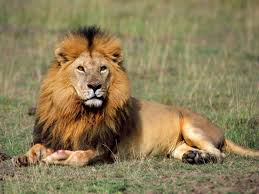

In [7]:
img = Image.open('{}/lion.png'.format(data_dir))
img

In [8]:
img = preinput(img)
prediction = model.predict(img)
show10results(prediction)

top 10 percentage category
  1  34.29% lion, king of beasts, Panthera leo
  2   5.01% chow, chow chow
  3   3.41% Pomeranian
  4   2.92% dhole, Cuon alpinus
  5   2.67% collie
  6   1.91% red fox, Vulpes vulpes
  7   1.85% Shetland sheepdog, Shetland sheep dog, Shetland
  8   1.67% Norwich terrier
  9   1.65% red wolf, maned wolf, Canis rufus, Canis niger
 10   1.18% hyena, hyaena


/Users/admin/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


# (2) estimating RF by reverse correlation 

In [9]:
pos = np.array([14,14]) #where unit
n_sample = 1000

In [ ]:
layer_name = 'conv1'

seed = 1
np.random.seed(seed)
img_inps = np.random.rand(n_sample,3,227,227).astype(np.float32) * 255
ua_list = []
#loop for collecting unit activations when random noise images are given
for k in range(n_sample):
    if np.mod(k,100)==0:
        print(k)
    img_inp = img_inps[k:k+1]
    feature = model(img_inp,layers=layer_name)[layer_name]
    unit_activation = feature[0,:,pos[0],pos[1]].data
    ua_list.append(unit_activation)

ua_list = np.array(ua_list)

In [16]:
#estimate RF
#unit activation * input
rf_rc = np.tensordot(img_inps,ua_list,axes = [0,0]).transpose(3,1,2,0)/n_sample

In [18]:
rf_rc_scaled = np.array([scaling(rf_rc[k]) for k in range(len(rf_rc))])

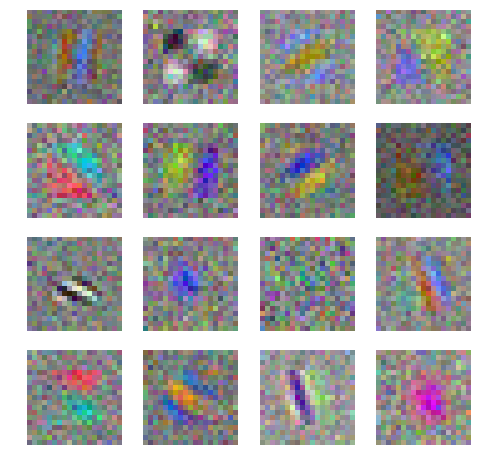

In [19]:
plt.figure(figsize=[8,8])
for ch in range(16):
    plt.subplot(4,4,ch+1)
    imshow_with_zoom(rf_rc_scaled[ch], pos = pos, zoom = True)
plt.savefig('{}/RF_rc'.format(fig_dir))

I compare the true weights and estimated RF in the following chapter 

# (3) estimating RF by activation maximization

In [11]:
#AM for RF
out_ch_len = 10
in_ch_len = 1
zure = 0

#estimate RF by AM
rf_am_img = []
for k in range(out_ch_len):
    print(k)
    img = Variable(np.random.rand(1,3,227,227).astype(np.float32))
    img_conv1 = am_reg('conv1', img,ch=k, pos = pos, pri = False, lam1 = 0.001, lam2 = 0, lr = 1, j=0, ite = 20)
    rf_am_img.append(img_conv1.data)

rf_am_imgs = np.vstack(rf_am_img)
rf_am_scaled = scaling(rf_am_imgs)
rf_am_scaled = rf_am_scaled.transpose(0,2,3,1)

0
1
2
3
4
5
6
7
8
9


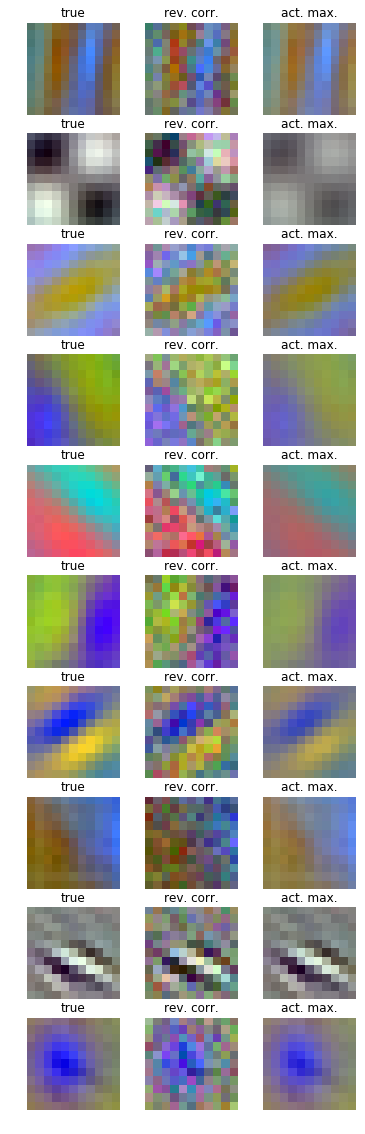

In [20]:
#plot
plt.figure(figsize=[6,2 * out_ch_len])
for out_ch in range(out_ch_len):
    for in_ch in range(in_ch_len):
        
        plt.subplot(out_ch_len,3,1 + 3*out_ch)
        true_weight = model.conv1.W.data[out_ch+zure].transpose(1,2,0)
        true_weight = scaling(true_weight)
        plt.imshow(true_weight)
        plt.axis('off')
        plt.title('true')
        plt.gray()
        
        plt.subplot(out_ch_len,3,2 + 3*out_ch)
        imshow_with_zoom(rf_rc_scaled[out_ch+zure,:,:], pos = pos, zoom=True,d=0)
        plt.title('rev. corr.')
        plt.gray()
        
        plt.subplot(out_ch_len,3,3 + 3*out_ch)
        imshow_with_zoom(rf_am_scaled[out_ch,:,:], pos = pos, zoom=True,d=0)
        plt.title('act. max.')
        plt.gray()
        

plt.savefig('{}/RF_rc_am.png'.format(fig_dir))

# (4) estimating prefered image by activation maximization (not only for first layer)

In [ ]:
img = Variable(np.random.rand(1,3,227,227).astype(np.float32))
img_conv3 = am_reg('conv3',img,pos=np.array([5,5]),ch=0,pri = False,lam1 = 0.0001,lam2 = 0.1,lr = 1,j=32,ite = 100)
img_conv3 = img_conv3.data

In [ ]:
img = Variable(np.random.rand(1,3,227,227).astype(np.float32))
img_fc6 = am_reg('fc6',img,ch=0,pri = False,lam1 = 0.0001,lam2 = 0.1,lr = 1,j=32,ite = 200)
img_fc6 = img_fc6.data

In [21]:
ch = 0
categories = np.loadtxt('{}/labels.txt'.format(data_dir), str, delimiter="\n")
categories[ch]

'tench, Tinca tinca'

In [ ]:
img = Variable(np.random.rand(1,3,227,227).astype(np.float32))
img_fc8 = am_reg('fc8',img,ch=ch,pri = False,lam1 = 0.0001,lam2 = 0.1,lr = 1,j=32,ite = 200)
img_fc8 = img_fc8.data

In [23]:
img_list = [img_conv3,img_fc6,img_fc8]
titles = ['conv3','fc6','fc8']

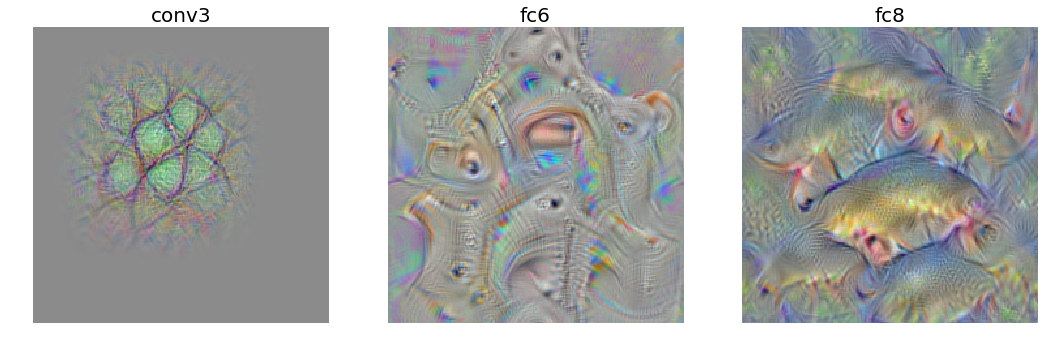

In [25]:
plt.figure(figsize = [18,6])
for k in range(len(img_list)):
    plt.subplot(1,len(img_list),k+1)
    show_chainer(img_list[k])
    plt.title(titles[k],fontsize = 20)

plt.savefig('{}/activation_maximization'.format(fig_dir))

In [28]:
prediction = model.predict(img_fc8)
show10results(prediction)

top 10 percentage category
  1 100.00% tench, Tinca tinca
  2   0.00% barracouta, snoek
  3   0.00% coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch
  4   0.00% gar, garfish, garpike, billfish, Lepisosteus osseus
  5   0.00% sturgeon
  6   0.00% axolotl, mud puppy, Ambystoma mexicanum
  7   0.00% eel
  8   0.00% goldfish, Carassius auratus
  9   0.00% puffer, pufferfish, blowfish, globefish
 10   0.00% tiger shark, Galeocerdo cuvieri


# (5) encoding and decoding experiment using Alexnet

In [ ]:
#load image data
with open('./data/Orientation.pickle','rb') as f:
    data_orientation = pickle.load(f)
with open('./data/ImageNet.pickle','rb') as f:
    data_image = pickle.load(f)
with open('./data/FMD.pickle','rb') as f:
    data_fmd = pickle.load(f)
    

In [35]:
#setting
ln_list = ['conv1','conv2','conv3','conv4','conv5','fc6','fc7','fc8']
n_unit=1000 #number of unit used in this analysis ( n <= 1000)
model.dropout_rate = 0.5 
n_train = 40 #training data size (n <= 40)
n_test = 10 #testing data size (n <= 10)


In [ ]:
# perform encoding decoding analysis
print('orientation start')
acc_orientation = encode_decode(data_orientation,n_unit,n_train,n_test,model)
print('imagenet start')
acc_imagenet = encode_decode(data_image,n_unit,n_train,n_test,model)
print('FMD start')
acc_fmd = encode_decode(data_fmd,n_unit,n_train,n_test,model)

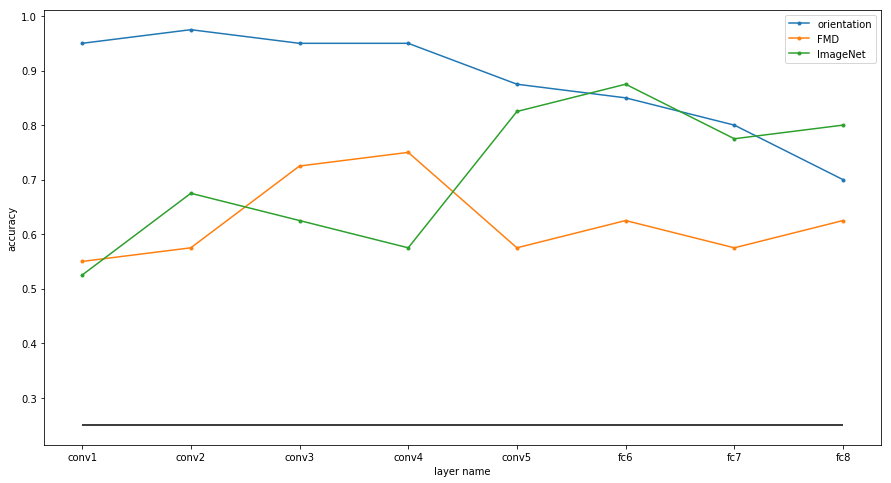

In [40]:
#plot
plt.figure(figsize=[15,8])
plt.plot(acc_orientation,'.-',label = 'orientation')
plt.plot(acc_fmd,'.-',label = 'FMD')
plt.plot(acc_imagenet,'.-',label = 'ImageNet')
plt.hlines(1.0/4,0,len(acc_fmd)-1)
a = plt.xticks(np.arange(len(acc_fmd)),ln_list)
plt.ylabel('accuracy')
plt.xlabel('layer name')
plt.legend()
plt.savefig('{}/enc_dec_acc'.format(fig_dir))

# (6) estimating tuning curve for orientation stimulus

In [37]:
#show orientation image to the model
m_list = []
s_list = []

n_ori = 32 # 
omega = 0.01 * 65

for k in range(n_ori + 1):
    img = make_data(np.pi /n_ori * k,omega)
    fea = F.relu(model(img,layers=['conv1'])['conv1'])[0].data
    m = [np.mean(f) for f in fea]
    s = [np.std(f) for f in fea]
    m_list.append(m)
    s_list.append(s)
    
s_list = np.array(s_list)
m_list = np.array(m_list)

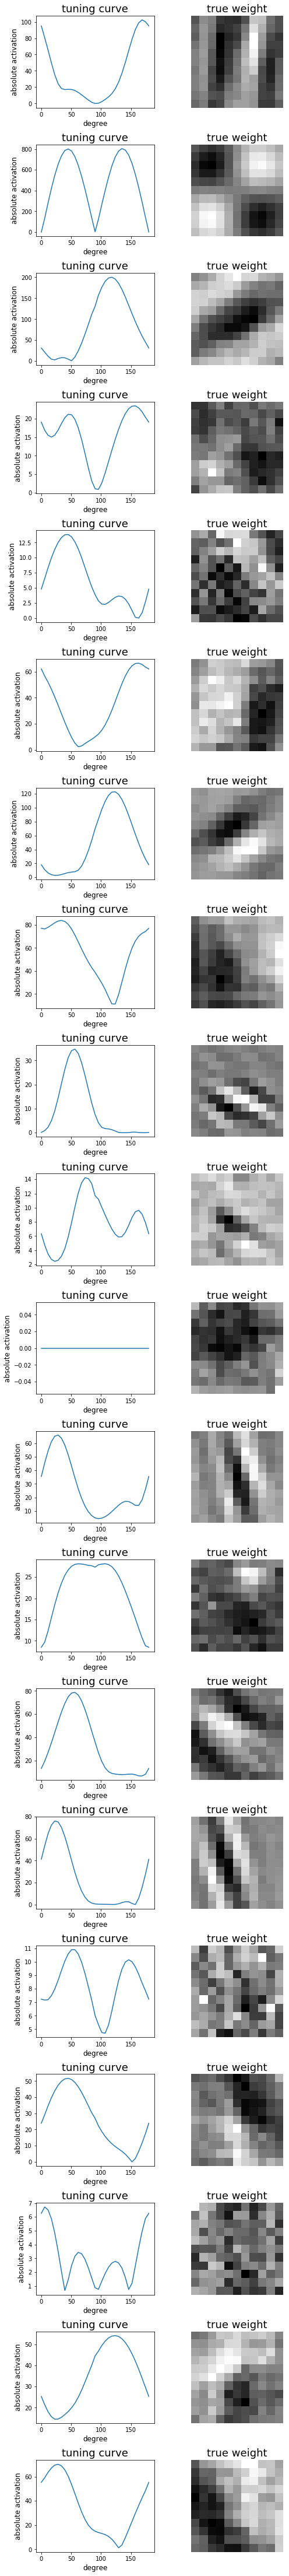

In [38]:
#plot
n_plot = 20
plt.figure(figsize=[4*2,4*n_plot])
for ch in range(n_plot):
    plt.subplot(n_plot,2,2*ch+1)

    temp_tuning = m_list[:,ch]
    temp_x = pi_to_deg(1.0 * np.arange(n_ori+1)/n_ori * np.pi)
    plt.plot(temp_x, temp_tuning)
    plt.ylabel('absolute activation',fontsize=12)
    plt.xlabel('degree',fontsize=12)
    plt.title('tuning curve',fontsize=18)

    plt.subplot(n_plot,2,2*ch+2)
    
    wei = np.mean(model.conv1.W[ch].transpose(1,2,0).data,axis=2)
    plt.imshow(wei)
    plt.axis('off')
    plt.title('true weight',fontsize = 18)
    
plt.subplots_adjust(hspace = 0.4)
plt.savefig('{}/tuning_curve_and_weight'.format(fig_dir))

# (7) decoding orientation using estimated tuning curve

In [41]:
theta_cand = np.linspace(0,np.pi,100)
ans_rec = []
for theta in theta_cand:
    img = make_data(theta,0.01 * 65,show = False)
    #img = np.expand_dims(img,axis=0)
    fea = F.relu(model(img,layers=['conv1'])['conv1']).data[0]
    
    #それぞれのchからユニットを一つずつ取ってくる
    b = [np.random.choice(fea[k].flatten()) for k in range(len(fea))]
    b = np.array(b)

    #尤度
    log_p = 0
    for k in range(len(b)):
        if np.random.rand() < 0.5:#約半分のチャネル
            m_interpolated = interpolate.interp1d(np.arange(33) * np.pi / 32.0,m_list[:,k])
            s_interpolated = interpolate.interp1d(np.arange(33) * np.pi / 32.0,s_list[:,k])
            m = m_interpolated(theta_cand)
            s = s_interpolated(theta_cand)
            log_p += log_gauss_p(b[k],m,s)
    ans = theta_cand[np.argmax(log_p)]
    ans_rec.append(ans)

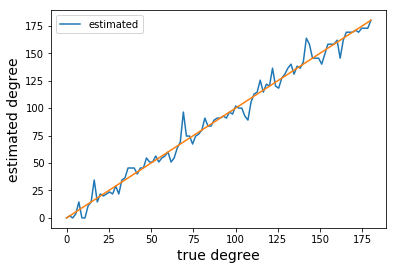

In [42]:
#plot
plt.plot(theta_cand/np.pi*180,np.array(ans_rec)/np.pi*180,label = 'estimated')
plt.plot(theta_cand/np.pi*180,theta_cand/np.pi*180)
plt.xlabel('true degree',fontsize = 14)
plt.ylabel('estimated degree',fontsize = 14)
plt.legend()
plt.savefig('{}/orientation_decoding'.format(fig_dir))

# (8) inverse CNN

In [47]:
#load image 
img_ori = Image.open('{}/geese.png'.format(data_dir))
img_ori = preinput(img_ori)

/Users/admin/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [48]:
ln_list = ['conv1','conv2','conv3','conv4','conv5','fc6','fc7','fc8']
#ln_list = ['fc6']
img_result_list = []
fea_size_list = []
for ln in ln_list:
    print(ln)
    
    #calculating original feature
    model.dropout_rate = 0.1
    fea_target = model(img_ori,layers = ln)[ln]
    
    #reconstruction from original feature
    model.dropout_rate = 0
    fea_size_list.append(fea_target.size)
    img = Variable(np.random.rand(1,3,227,227).astype(np.float32))
    img = icnn(ln,img,fea_target,pri = True,ite = 300,lam1 =0.01,lam2 = 0.1,lr = 1)
    img = icnn(ln,img,fea_target,pri = True,ite = 300,lam1 =0.01,lam2 = 0.1,lr = 0.1)
    img_result_list.append(img.data)

conv1
conv2
conv3
conv4
conv5
fc6
fc7
fc8


In [50]:
with open('{}/inverse.pkl'.format(temp_dir),'rb') as f:
    img_result_list = pickle.load(f)

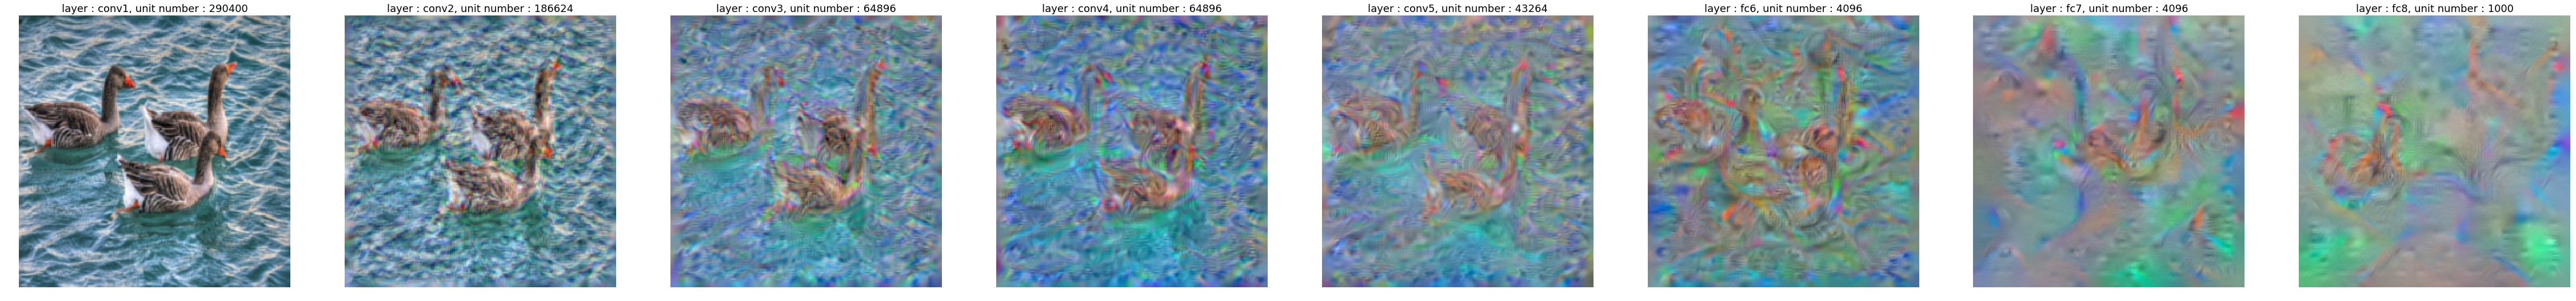

In [51]:
plt.figure(figsize=[80,10])
for k in range(len(img_result_list)):
    plt.subplot(1,len(img_result_list),k+1)
    show_chainer(img_result_list[k])
    plt.title('layer : {}, unit number : {}'.format(ln_list[k],fea_size_list[k]),fontsize = 18)
    plt.axis('off')
plt.savefig('{}/icnn'.format(fig_dir))

# (9) deepdream googlenet
(alexnetでやると、あまり面白い結果にならなかったので、）

In [55]:
if not os.path.exists('fig_dream'):
    os.mkdir('fig_dream')
#load googlenet model
model = GoogleNet('{}/bvlc_googlenet.caffemodel'.format(model_dir))

ln = 'inception_4c/output'

from lion image

In [60]:
img = Image.open('{}/lion.png'.format(data_dir))
img = preinput(img)

/Users/admin/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [61]:
t = datetime.now().strftime('%Y%m%dT%H%M%S')
#optimization loop
for k in range(30):
    print(k)
    img,detail_rec,x_rec = update(img,model,ln)
    a = Image.fromarray(img[0,[2,1,0]].transpose(1,2,0).astype(np.uint8))
    a.save('fig_dream/{}_{}th.png'.format(t,k))
    print('fig_dream/{}_{}th.png is saved'.format(t,k))

0


/Users/admin/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


fig_dream/20180319T174743_0th.png is saved
1
fig_dream/20180319T174743_1th.png is saved
2
fig_dream/20180319T174743_2th.png is saved
3
fig_dream/20180319T174743_3th.png is saved
4
fig_dream/20180319T174743_4th.png is saved
5
fig_dream/20180319T174743_5th.png is saved
6
fig_dream/20180319T174743_6th.png is saved
7
fig_dream/20180319T174743_7th.png is saved
8
fig_dream/20180319T174743_8th.png is saved
9
fig_dream/20180319T174743_9th.png is saved
10
fig_dream/20180319T174743_10th.png is saved
11
fig_dream/20180319T174743_11th.png is saved
12
fig_dream/20180319T174743_12th.png is saved
13
fig_dream/20180319T174743_13th.png is saved
14
fig_dream/20180319T174743_14th.png is saved
15
fig_dream/20180319T174743_15th.png is saved
16
fig_dream/20180319T174743_16th.png is saved
17
fig_dream/20180319T174743_17th.png is saved
18
fig_dream/20180319T174743_18th.png is saved
19
fig_dream/20180319T174743_19th.png is saved
20
fig_dream/20180319T174743_20th.png is saved
21
fig_dream/20180319T174743_21th.p

inception_4c/output


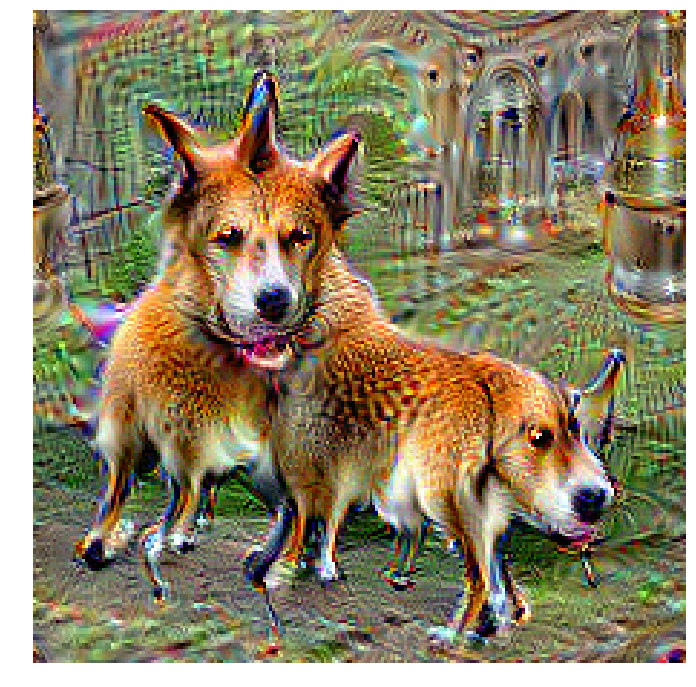

In [62]:
print(ln)
plt.figure(figsize=[12,12])
show_chainer(img)

from random image



In [63]:
img = np.random.randn(1,3,200,200).astype(np.float32)*1

In [64]:
t = datetime.now().strftime('%Y%m%dT%H%M%S')
#optimization loop
for k in range(30):
    print(k)
    img,detail_rec,x_rec = update(img,model,ln)
    a = Image.fromarray(img[0,[2,1,0]].transpose(1,2,0).astype(np.uint8))
    a.save('fig_dream/{}_{}th.png'.format(t,k))
    print('fig_dream/{}_{}th.png is saved'.format(t,k))


0


/Users/admin/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


fig_dream/20180319T175405_0th.png is saved
1
fig_dream/20180319T175405_1th.png is saved
2
fig_dream/20180319T175405_2th.png is saved
3
fig_dream/20180319T175405_3th.png is saved
4
fig_dream/20180319T175405_4th.png is saved
5
fig_dream/20180319T175405_5th.png is saved
6
fig_dream/20180319T175405_6th.png is saved
7
fig_dream/20180319T175405_7th.png is saved
8
fig_dream/20180319T175405_8th.png is saved
9
fig_dream/20180319T175405_9th.png is saved
10
fig_dream/20180319T175405_10th.png is saved
11
fig_dream/20180319T175405_11th.png is saved
12
fig_dream/20180319T175405_12th.png is saved
13
fig_dream/20180319T175405_13th.png is saved
14
fig_dream/20180319T175405_14th.png is saved
15
fig_dream/20180319T175405_15th.png is saved
16
fig_dream/20180319T175405_16th.png is saved
17
fig_dream/20180319T175405_17th.png is saved
18
fig_dream/20180319T175405_18th.png is saved
19
fig_dream/20180319T175405_19th.png is saved
20
fig_dream/20180319T175405_20th.png is saved
21
fig_dream/20180319T175405_21th.p

inception_4c/output


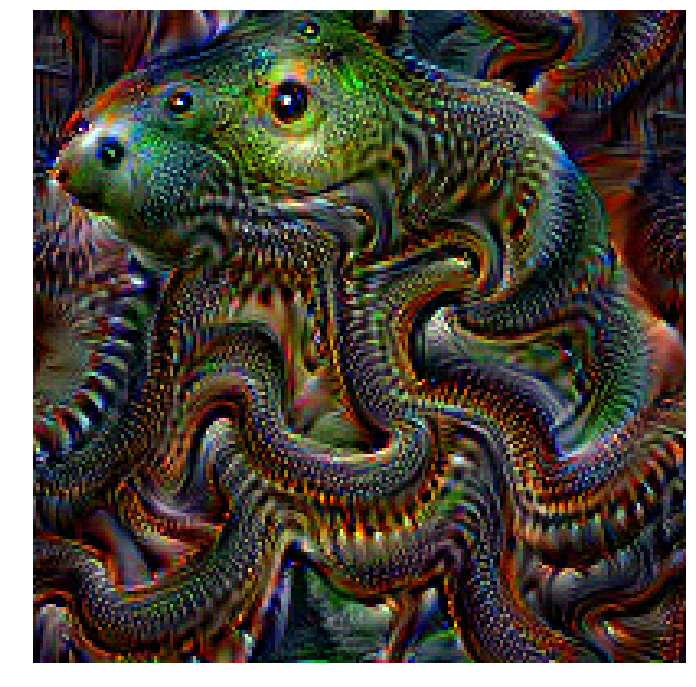

In [65]:
print(ln)
plt.figure(figsize=[12,12])
show_chainer(img)